In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from datetime import datetime
from arch import arch_model

In [2]:
# 5 years of data of Russell 1000 and 25 top components
df = pd.read_csv('C:/Users/shu_n/Desktop/Kepler CS/Data/russ.csv', sep=';',index_col=['Date'])
df.head()

,AAPL,AMZN,BA,BAC,BRK-B,CSCO,CVX,FB,GOOG,HD,...,PFE,PG,T,UNH,V,VZ,WFC,WMT,XOM,RUI
Date,,,,,,,,,,,,,,,,,,,,,
14/01/2015,109.800003,293.269989,130.380005,16.040001,147.820007,27.92,103.900002,76.279999,499.498627,102.639999,...,32.480000,89.989998,33.330002,103.330002,63.889999,46.970001,51.250000,86.610001,89.739998,1118.859985
15/01/2015,106.820000,286.950012,130.139999,15.200000,147.580002,27.41,102.669998,74.050003,500.416107,101.010002,...,32.400002,89.860001,33.259998,104.459999,63.282501,47.099998,50.720001,87.379997,88.959999,1108.319946
16/01/2015,105.989998,290.739990,130.779999,15.380000,149.210007,27.68,105.120003,75.180000,506.688873,104.120003,...,32.799999,91.250000,33.799999,105.769997,63.737499,47.990002,51.639999,86.769997,91.120003,1123.109985
20/01/2015,108.720001,289.440002,131.220001,15.260000,148.630005,28.07,106.470001,76.239998,505.512115,103.250000,...,33.099998,91.190002,33.950001,105.620003,64.209999,48.180000,52.000000,86.690002,91.089996,1124.479980
21/01/2015,109.550003,297.250000,132.410004,15.410000,147.179993,27.84,108.160004,76.739998,516.621643,103.529999,...,32.639999,90.730003,34.000000,109.320000,64.320000,48.250000,52.099998,86.639999,91.870003,1130.000000


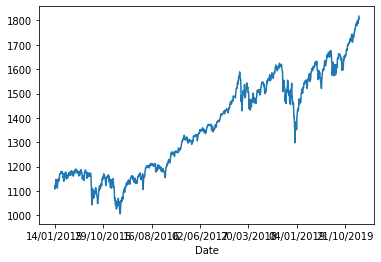

In [3]:
df['RUI'].plot()
plt.show()

Using log-normal returns:

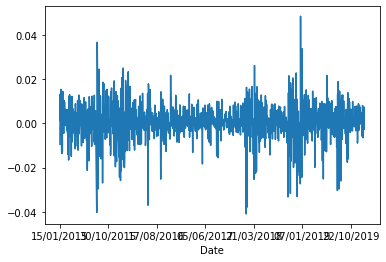

In [4]:
x = df['RUI']
rui_log = np.log(x[1:] / x[:-1].values)
rui_log.plot()
plt.show()

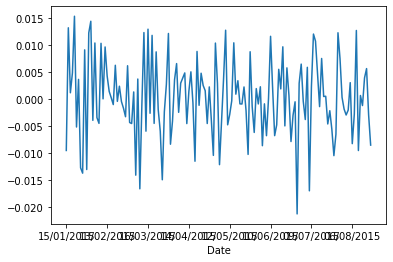

In [5]:
train_start, train_end, test_start, test_end = 0, 150, 150, 170
rui_train = rui_log[train_start:train_end]
rui_test = rui_log[test_start:test_end]
rui_train.plot()
plt.show()

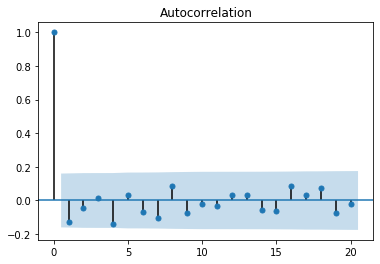

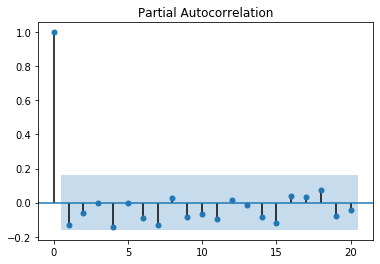

In [6]:
sm.tsa.graphics.plot_acf(rui_train, lags=20, alpha=0.05)
sm.tsa.graphics.plot_pacf(rui_train, lags=20, alpha=0.05)
plt.show()

In [7]:
aic = np.inf
winner = [0,0]
best_md = None
for i in range(0,5):
    for j in range(0,5):
        try:
            mdl = sm.tsa.ARMA(rui_train.values,order=(i,j)) #'.values' to get rid of warning
            res = mdl.fit(trend='nc',method='mle',maxiter=1000)
            if res.aic < aic:
                aic = res.aic
                winner = [i,j]
        except (ValueError) as e: 
            continue

In [8]:
print("Best couple: " + str(winner) +  " with AIC = " + str(aic))

Best couple: [1, 1] with AIC = -1056.5288729854847


In [33]:
mdl = sm.tsa.ARMA(rui_train.values,[1,1])
res = mdl.fit(trend='nc',method='mle')
print(res.params)

lbt = sm.stats.diagnostic.acorr_ljungbox(res.resid, lags=[20], boxpierce=False)
print(lbt)

score, pvalue, _, _ = jarque_bera(res.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')
    
print("Score: %f, P-value: %f" % (score,pvalue))

[ 0.76615991 -0.90937517]
(array([10.94608312]), array([0.94760878]))
The residuals seem normally distributed.
Score: 3.475638, P-value: 0.175904


C:\Users\shu_n\Anaconda2\envs\py36\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


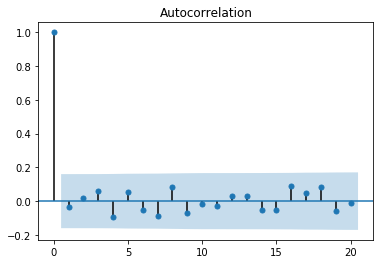

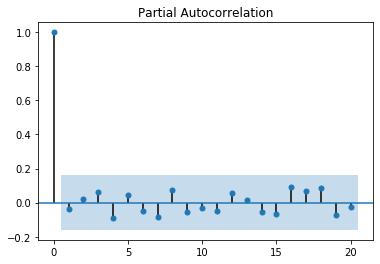

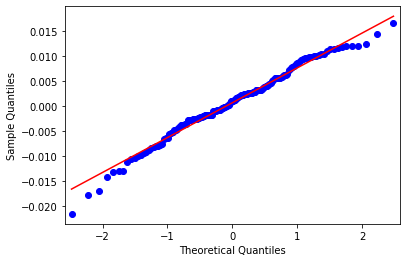

In [10]:
sm.tsa.graphics.plot_acf(res.resid, lags=20, alpha=0.05)
sm.tsa.graphics.plot_pacf(res.resid, lags=20, alpha=0.05)
sm.qqplot(res.resid, line='s')  
plt.show()

In [11]:
pred_out, err95, ci95 = res.forecast(steps=20)

In [12]:
#converting dates to the right format
dt_train = []
for i in rui_train.index.values:
    dt_train.append(datetime.strptime(i, '%d/%m/%Y'))

dt_test = []
for i in rui_test.index.values:
    dt_test.append(datetime.strptime(i, '%d/%m/%Y'))

In [13]:
pred_out_df = pd.DataFrame(pred_out, index=dt_test, columns=['forecast'])

In [14]:
ci95_df = pd.DataFrame(np.column_stack([ci95]),index=dt_test, columns=['lower','upper'])
ci95_df.head()

,lower,upper
2015-08-20,-0.012736,0.014712
2015-08-21,-0.013107,0.014621
2015-08-24,-0.013366,0.014525
2015-08-25,-0.013549,0.014437
2015-08-26,-0.013681,0.014361


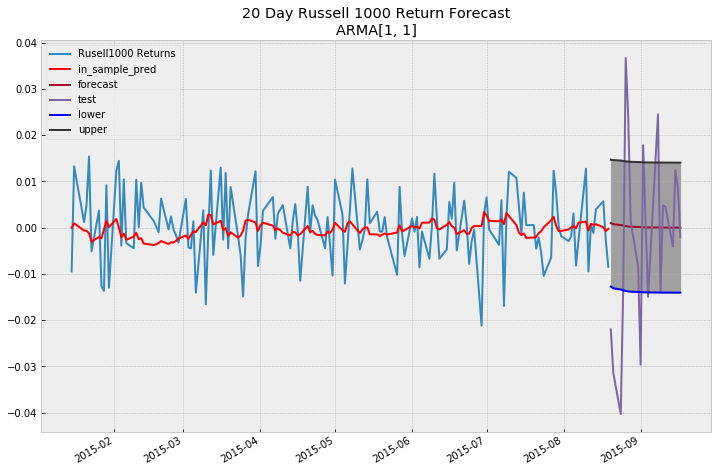

In [18]:
plt.style.use('bmh')
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
ts = rui_train.copy()

# in sample prediction
pred = res.predict(0, len(ts) - 1)
ts.index = dt_train
pred_df = pd.DataFrame(pred, index=ts.index, columns=['in_sample_pred'])

ts.plot(ax=ax, label='Rusell1000 Returns')
pred_df.plot(ax=ax, style='r-', label='In-sample prediction')
pred_out_df.plot(ax=ax, label='pred_out')
rui_test_df = pd.DataFrame(rui_test.values, index=dt_test, columns=['test'])
rui_test_df.plot(ax=ax, label='test')
styles = ['b-', '0.2', '0.2']
ci95_df.plot(ax=ax, style=styles)
plt.fill_between(ci95_df.index, ci95_df.lower, ci95_df.upper, color='gray', alpha=0.7)
plt.title('{} Day Russell 1000 Return Forecast\nARMA{}'.format(20,winner))

plt.legend(loc='best', fontsize=10)
plt.show()

In [19]:
S0 = x[150]
tmp = np.exp(pred_out_df.values)
pred_og_arma = np.zeros(len(tmp)+1)
pred_og_arma[0] = S0
for i in range(len(tmp)):
    pred_og_arma[i+1] = S0 * tmp[i]
    S0 = S0 * tmp[i]

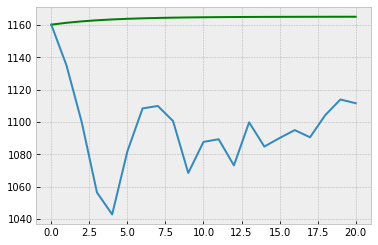

In [20]:
plt.plot(pred_og_arma,'-g')
plt.plot(x[150:171].values)
plt.show()

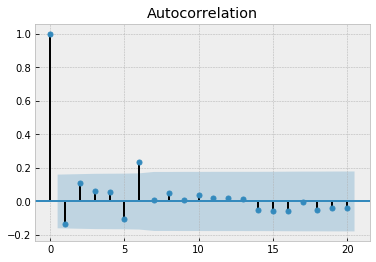

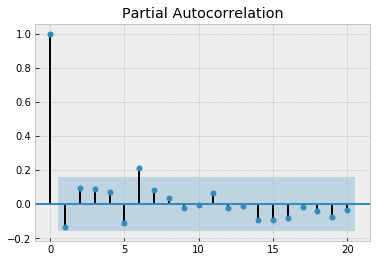

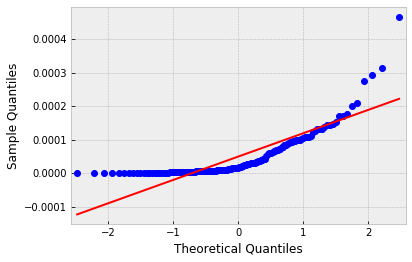

In [21]:
sm.tsa.graphics.plot_acf(res.resid ** 2, lags=20, alpha=0.05)
sm.tsa.graphics.plot_pacf(res.resid ** 2, lags=20, alpha=0.05)
sm.qqplot(res.resid ** 2, line='s')  
plt.show()

In [22]:
am = arch_model(res.resid, p=1, o=0, q=1, dist='StudentsT')
arch_fitted = am.fit(update_freq=5, disp='off')
print(arch_fitted.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                532.907
Distribution:      Standardized Student's t   AIC:                          -1055.81
Method:                  Maximum Likelihood   BIC:                          -1040.76
                                              No. Observations:                  150
Date:                      Thu, Apr 30 2020   Df Residuals:                      145
Time:                              11:45:32   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

C:\Users\shu_n\Anaconda2\envs\py36\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.875e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


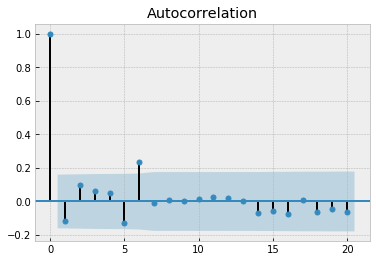

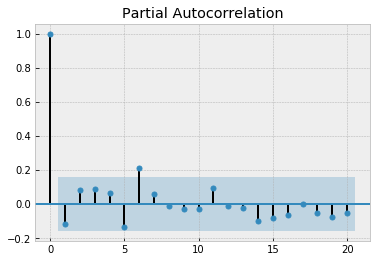

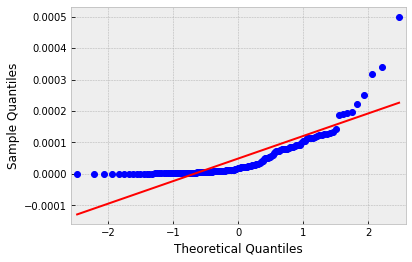

In [23]:
sm.tsa.graphics.plot_acf(arch_fitted.resid ** 2, lags=20, alpha=0.05)
sm.tsa.graphics.plot_pacf(arch_fitted.resid ** 2, lags=20, alpha=0.05)
sm.qqplot(arch_fitted.resid ** 2, line='s')  
plt.show()

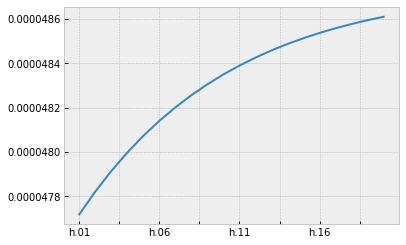

In [24]:
#start = np.datetime64('2015-09-06')
forecasts = arch_fitted.forecast(start=None, horizon=20)
forecasts.variance.iloc[-1].plot()
plt.show()

In [25]:
w = np.random.randn(20)
pred_garch = forecasts.mean.iloc[-1].values + np.sqrt(forecasts.variance.iloc[-1].values)*w
pred_garch_df = pd.DataFrame(pred_garch, index=dt_test,columns=['pred_garch'])

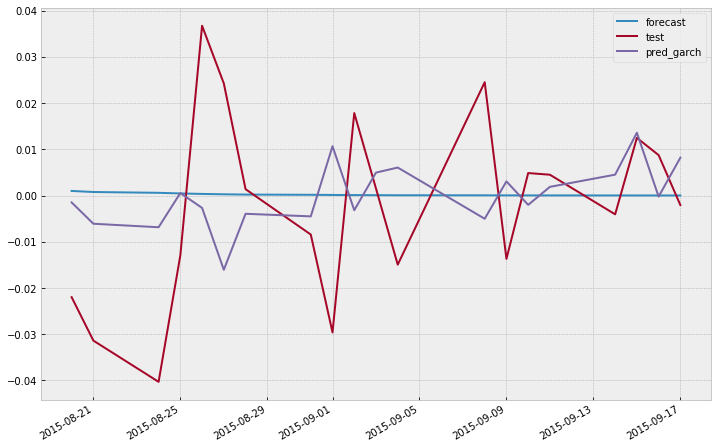

In [26]:
plt.style.use('bmh')
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

pred_out_df.plot(ax=ax, label='pred_arma')
rui_test_df.plot(ax=ax,label='test')
pred_garch_df.plot(ax=ax,label='pred')
plt.legend(loc='best', fontsize=10)
plt.show()

In [27]:
S0 = x[150]
tmp = np.exp(pred_garch_df.values)
pred_og_garch = np.zeros(len(tmp)+1)
pred_og_garch[0] = S0
for i in range(len(tmp)):
    pred_og_garch[i+1] = S0 * tmp[i]
    S0 = S0 * tmp[i]

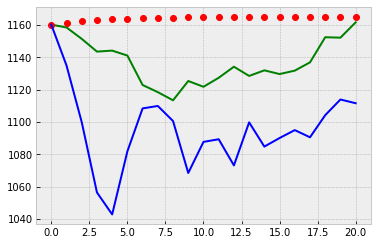

In [28]:
plt.plot(pred_og_garch, 'g')
plt.plot(pred_og_arma,'ro')
plt.plot(x[150:171].values,'b')
plt.show()

GARCH model is a better estimator.